In [3]:
import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html
#import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
from scipy import stats    #Used for 2D binned statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
import cartopy.crs as ccrs
        
#import spectrum

#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 


In [ ]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

### load sst of smt and satellite data

In [32]:
### temperature and salt
path_data = f'/work/mh0033/u241317/smt/time_series_analysis/tseries_sst.nc'
dh = xr.open_dataset(path_data)
time0 = np.datetime64('2010-01-09T01:00:00')
dti = pd.date_range(time0, periods=984, freq="2h")
dh = dh.assign_coords(time=dti)
N = 984
K = np.arange(N)
ncells = 4000
sst_mean_num = dh.T001_sp.mean('time')

In [143]:
sst_mean_num_month = dh.T001_sp.resample(time="1M").mean(dim="time")
sst_mean_num_month

<xarray.DataArray 'T001_sp' (time: 3, ncells: 4000)>
array([[14.442319 , 14.446891 , 14.443757 , ...,  3.577011 ,  3.6125636,
         3.6362343],
       [13.773765 , 13.789831 , 13.7970915, ...,  2.848672 ,  2.8764927,
         2.8827593],
       [14.421224 , 14.422242 , 14.417017 , ...,  5.0564237,  5.0824738,
         5.109019 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 2010-03-31
    clon     (ncells) float64 -9.998 -10.02 -10.03 ... -74.97 -74.98 -75.0
    clat     (ncells) float64 39.0 38.99 39.0 39.0 39.01 ... 39.0 39.0 39.0 39.0
    rlon     (ncells) float64 -10.0 -10.02 -10.03 -10.05 ... -74.97 -74.98 -75.0
    rlat     (ncells) float64 39.0 39.0 39.0 39.0 39.0 ... 39.0 39.0 39.0 39.0
Dimensions without coordinates: ncells

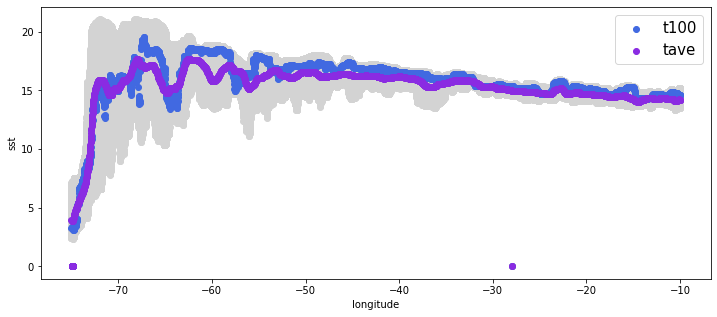

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for k in K:
    plt.scatter(dh.rlon, dh.T001_sp.isel(time=k), color="lightgrey")

plt.scatter(dh.rlon, dh.T001_sp.isel(time=100), color="royalblue", label="t100")
plt.scatter(dh.rlon, sst_mean_num, color="blueviolet", label="tave")
plt.xlabel('longitude')
plt.ylabel('sst')
plt.legend(fontsize=15)

satellite

In [162]:
### temperature and salt
path_data = f'/work/mh0033/u241317/satellite/sst/sst_m_sat_day.nc'
dh_sat = xr.open_dataset(path_data)
#time0 = np.datetime64('2010-01-09T01:00:00')
#dti = pd.date_range(time0, periods=984, freq="2h")
#dh = dh.assign_coords(time=dti)
Nsat = 3
Ksat = np.arange(Nsat)
ncells = 1560
sst_mean_sat = dh_sat.sst_day.mean('time')

## march satellite data not available

In [158]:
dh_sat.sst_day

<xarray.DataArray 'sst_day' (time: 3, lon: 1560)>
array([[      nan,       nan,       nan, ..., 14.299999, 14.299999, 14.139999],
       [      nan,       nan,       nan, ..., 14.2     , 14.16    , 14.099999],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
    lat      float32 39.98
  * lon      (lon) float32 -74.98 -74.94 -74.9 -74.85 ... -10.1 -10.06 -10.02
  * time     (time) datetime64[ns] 2010-01-16 2010-02-13 2010-03-16
Attributes:
    long_name:    Sea surface temperature at day
    units:        degree Celsius
    valid_range:  [-200 4500]

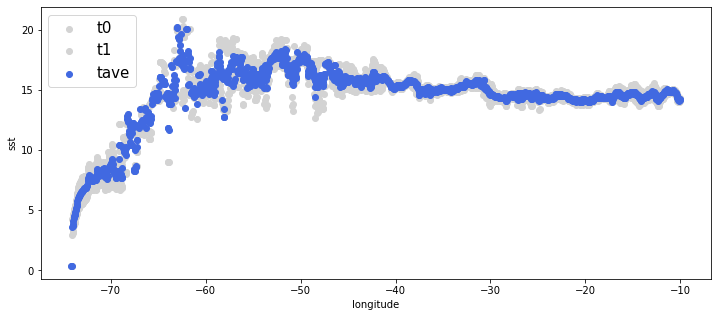

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

plt.scatter(dh_sat.lon, dh_sat.sst_day.isel(time=0), color="lightgray", label="t0")
plt.scatter(dh_sat.lon, dh_sat.sst_day.isel(time=1), color="lightgray", label="t1")
#plt.scatter(dh_sat.lon, dh_sat.sst_day.isel(time=2), color="lightgray", label="t2")
plt.scatter(dh_sat.lon, sst_mean_sat, color="royalblue", label="tave")
plt.xlabel('longitude')
plt.ylabel('sst')
plt.legend(fontsize=15)

In [163]:
### sampling distance
dm_num = dh.rlon[0] - dh.rlon[1]
dm_sat = dh_sat.lon[1] - dh_sat.lon[0]
print('in degrees:', 'model', dm_num.data, 'satellite', dm_sat.data)
# convert to meter
r = 6371000
const_lat = 40 # latitude of section
latitude = np.linspace(0,90,90)
delta = 2*np.pi*r/360*np.cos(latitude/90* np.pi/2)
print('distance of one degree in meter at equator', delta[0])
print('distance of one degree in meter at section', delta[const_lat])

dm_num = dm_num.data * delta[const_lat]
dm_sat = dm_sat.data * delta[const_lat]
print('in meter:', 'model', dm_num, 'satellite', dm_sat)

in degrees: model 0.01625406351587877 satellite 0.041671753
distance of one degree in meter at equator 111194.92664455873
distance of one degree in meter at section 84616.98048314604
in meter: model 1375.36977529493 satellite 3526.137904349851


## non smoothed spectral estimates

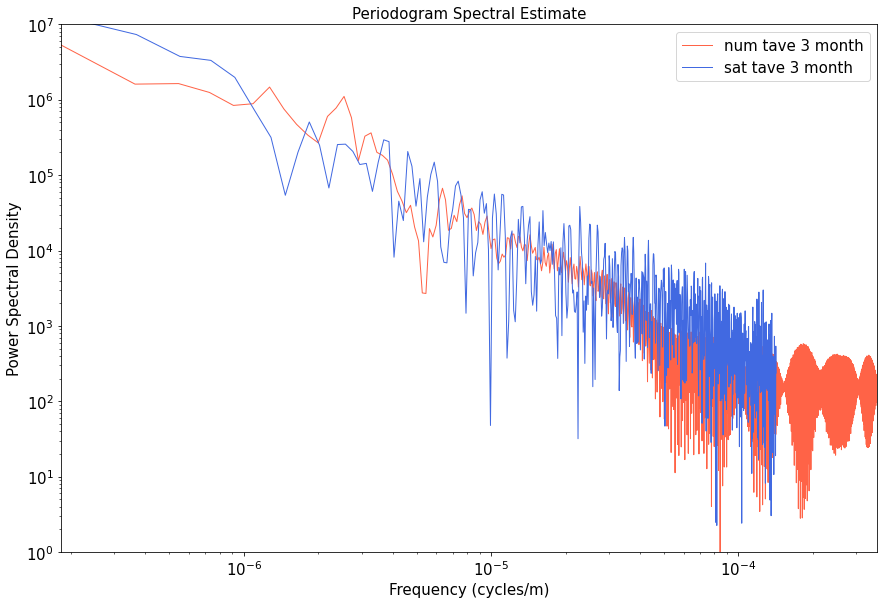

In [164]:
# there is no march satellite data!!!!!!!!

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# model
cv = sst_mean_num # 3month average
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dm_num)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1, color="tomato", label="num tave 3 month")
# satellite
cv = sst_mean_sat[20:].data #3month average
nans, x= nan_helper(cv) # linear interpolation
cv[nans]= np.interp(x(nans), x(~nans), cv[~nans])
f, S = sg.periodogram(cv-np.nanmean(cv), fs=1/dm_sat)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1, color="royalblue", label="sat tave 3 month")

ax.autoscale(enable=True, tight=True)
ax.set_ylim(1e0, 1e7)
fig.tight_layout()

plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/m)', fontsize=15)
plt.ylabel('Power Spectral Density',fontsize=15)
plt.title('Periodogram Spectral Estimate',fontsize=15);
#plt.savefig('../images/periodogram_ssh', bbox_inches='tight')

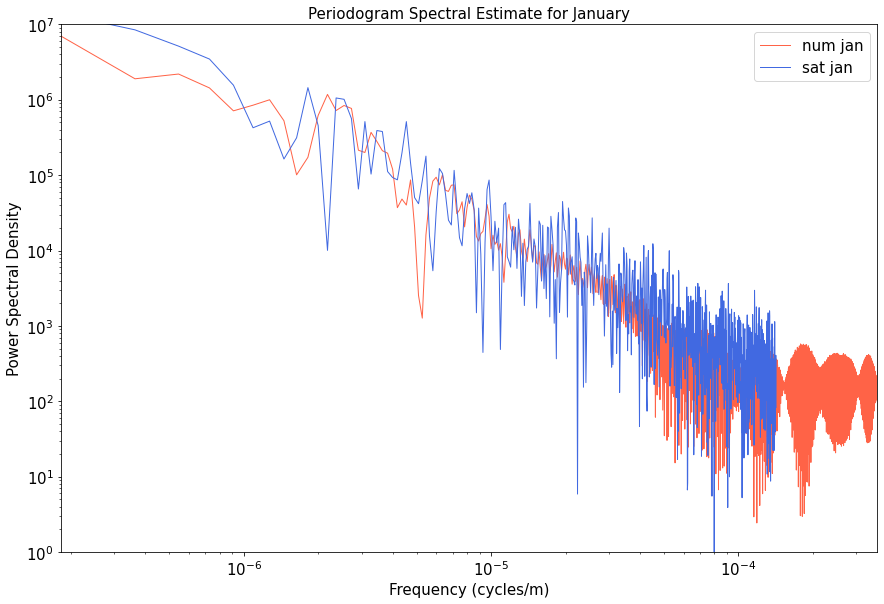

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# model
cv = sst_mean_num_month.isel(time=0).data # january average
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dm_num)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1, color="tomato", label="num jan")
# satellite
cv = dh_sat.sst_day.isel(time=0).data #january average
nans, x= nan_helper(cv) # linear interpolation
cv[nans]= np.interp(x(nans), x(~nans), cv[~nans])
f, S = sg.periodogram(cv-np.nanmean(cv), fs=1/dm_sat)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1, color="royalblue", label="sat jan")

ax.autoscale(enable=True, tight=True)
ax.set_ylim(1e0, 1e7)
fig.tight_layout()

plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/m)', fontsize=15)
plt.ylabel('Power Spectral Density',fontsize=15)
plt.title('Periodogram Spectral Estimate for January',fontsize=15);
#plt.savefig('../images/periodogram_ssh', bbox_inches='tight')

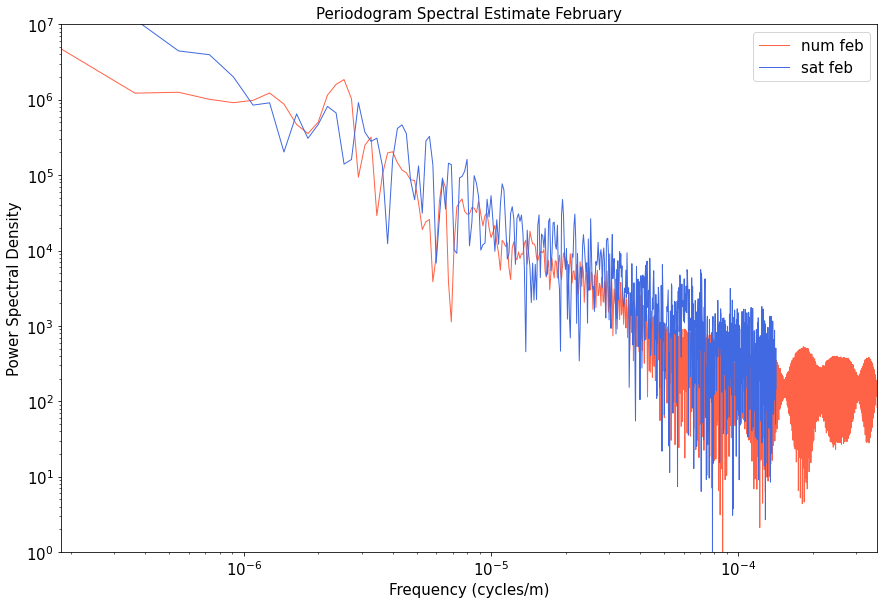

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# model
cv = sst_mean_num_month.isel(time=1).data # january average
f, S = sg.periodogram(cv-np.mean(cv), fs=1/dm_num)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1, color="tomato", label="num feb")
# satellite
cv = dh_sat.sst_day.isel(time=1).data #january average
nans, x= nan_helper(cv) # linear interpolation
cv[nans]= np.interp(x(nans), x(~nans), cv[~nans])
f, S = sg.periodogram(cv-np.nanmean(cv), fs=1/dm_sat)
ax.loglog(f[np.where(f>=0)], S[np.where(f>=0)], linewidth=1, color="royalblue", label="sat feb")

ax.autoscale(enable=True, tight=True)
ax.set_ylim(1e0, 1e7)
fig.tight_layout()

plt.legend(fontsize=15)
ax.tick_params(labelsize=15)
plt.xlabel('Frequency (cycles/m)', fontsize=15)
plt.ylabel('Power Spectral Density',fontsize=15)
plt.title('Periodogram Spectral Estimate February',fontsize=15);
#plt.savefig('../images/periodogram_ssh', bbox_inches='tight')